# Diagnostic Breast Cancer Wisconsin<a href="# Diagnostic Breast Cancer Wisconsin" class="anchor-link">¶</a>
- Carry out a classification analysis considering the following setting.
    - Apply a 10-fold cross-validation procedure on the Breast cancer wisconsin (diagnostic) dataset to identify the most suitable classifier among the following
        * Logistic Regression (default params)
        * Logistic Regression (default params) after oversampling with SMOTE
    - Report and discuss the results, motivating the choice of the most suitable model

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

In [2]:
breast = datasets.load_breast_cancer()
X, y = breast.data, breast.target
pd.Series(y).value_counts()

1    357
0    212
Name: count, dtype: int64

In [3]:
estimators = [('scaling',StandardScaler()),
              ('clf', LogisticRegression())]
pipe_original = Pipeline(estimators)
pipe_original

Pipeline(steps=[('scaling', StandardScaler()), ('clf', LogisticRegression())])

In [4]:
def eval_cross_validation(pipeline, skf, X, y):
    list_df = []
    list_accuracy = []

    k = 1
    for train, val in skf.split(X, y):
        # fit and predict using pipeline
        X_tr = X[train]
        y_tr = y[train]
        X_val = X[val]
        y_val = y[val]
        pipeline.fit(X_tr,y_tr)
        y_pred = pipeline.predict(X_val)
        # compute classification report
        cr = classification_report(y_val,y_pred,output_dict = True)
        # store accuracy
        list_accuracy.append(cr['accuracy'])
        # store per-class metrics as a dataframe
        df = pd.DataFrame({k:v for k,v in cr.items() if k!='accuracy'})
        list_df.append(df)
        print(f'FOLD {k}')
        k+=1


    # compute average per-class metrics    
    df_concat = pd.concat(list_df)
    grouped_by_row_index = df_concat.groupby(df_concat.index)
    df_avg = grouped_by_row_index.mean()
    
    # compute average accuracy
    accuracy_avg = np.mean(list_accuracy)
    return df_avg, accuracy_avg 

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
df_original, acc_original = eval_cross_validation(pipe_original, skf, X, y)

FOLD 1
FOLD 2
FOLD 3
FOLD 4
FOLD 5
FOLD 6
FOLD 7
FOLD 8
FOLD 9
FOLD 10


In [6]:
df_original.round(3)

,0,1,macro avg,weighted avg
f1-score,0.964,0.979,0.971,0.973
precision,0.972,0.976,0.974,0.975
recall,0.958,0.983,0.971,0.974
support,21.200,35.700,56.900,56.900


In [7]:
acc_original

0.9736842105263157

The original classifier obtains satisfactory results in the task, with an average accuracy higher than 0.97 and high values of precision and recall on both classes (greater than 0.95). The slight imbalance between classes (in a ratio around 3:2) does not affect particularly the results.

In [10]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pipe_smote = Pipeline([
        ('sampling', SMOTE(random_state = 123)),
        ('scaling',StandardScaler()),
        ('classification', LogisticRegression())
    ])

In [11]:
df_smote, acc_smote = eval_cross_validation(pipe_smote, skf, X, y)

FOLD 1
FOLD 2
FOLD 3
FOLD 4
FOLD 5
FOLD 6
FOLD 7
FOLD 8
FOLD 9
FOLD 10


In [12]:
df_smote.round(3)

,0,1,macro avg,weighted avg
f1-score,0.969,0.982,0.975,0.977
precision,0.972,0.981,0.977,0.978
recall,0.967,0.983,0.975,0.977
support,21.200,35.700,56.900,56.900


In [13]:
acc_smote

0.9771929824561404

The recall on the minority class slighly increases (on average, from 0.958 to 0.967).

In the following, we adopt the wilcoxon test to assess if there is significant difference among the distribution of the f1-scores of the positive class.

In [14]:
fscore_original = cross_val_score(pipe_original, 
                                  X, 
                                  y, 
                                  scoring ='f1',
                                  cv = skf)

In [15]:
fscore_original.mean()

0.9793612345770739

In [16]:
fscore_smote = cross_val_score(pipe_smote, 
                                  X, 
                                  y, 
                                  scoring ='f1',
                                  cv = skf)

In [17]:
fscore_smote.mean()

0.9819543071016532

In [18]:
metrics = pd.DataFrame({'original': fscore_original, 'smote': fscore_smote})
metrics

,original,smote
0,0.958904,0.972222
1,0.985507,0.985507
2,0.933333,0.945946
3,0.972222,0.972222
4,0.986301,0.986301
5,1.000000,1.000000
6,0.985915,0.985915
7,1.000000,1.000000
8,0.971429,0.971429
9,1.000000,1.000000


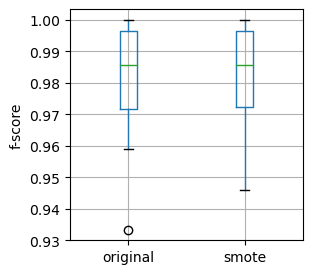

In [19]:
from matplotlib import pyplot as plt
ax = metrics.boxplot(figsize = (3,3))
ax.set_ylabel('f-score')
plt.show()

In [20]:
from scipy.stats import wilcoxon
wilcoxon(metrics.original, metrics.smote)

/Users/marysia/miniconda3/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/marysia/miniconda3/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)

Given the confidence level *α=0.05*, we can conclude that as **p-value** > α, the null hypothesis (that the two related paired samples come from the same distribution) **cannot be rejected**.

We can conclude that there is no significant difference between the two classification pipelines (no rebalancing and oversampling with SMOTE) in terms of the chosen classification metric (f1-score).

The classification pipeline without rebalancing can be regarded as the most suitable one: the improvement brought by SMOTE is not-significant, thus the simplest classification pipeline should be chosen.